# Sailors

### Requirements

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

# Add the src directory to the path
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('..'))

# Import the BaseAgent class
from src.agents.base_agent import BaseAgent

from src.env_sailing import SailingEnv
from src.initial_windfields import get_initial_windfield

# Display the BaseAgent class documentation
#help(BaseAgent)

## I. Mousse_1

### Defining Agent

In [ ]:
class Mousse_1(BaseAgent):
    """A minimal valid agent that meets all interface requirements."""
    
    def __init__(self, learning_rate=0.1, discount_factor=0.9, exploration_rate=0.1):
        super().__init__()
        self.np_random = np.random.default_rng()

        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate

        self.position_bins = 32     # Discretize the grid into 32 x 32
        self.velocity_bins = 8     # Discretize velocity into 4 bins
        self.wind_bins = 8         # Discretize wind directions into 8 bins

        self.q_table = {}

        self.complexity = self.position_bins * self.position_bins * self.velocity_bins * self.wind_bins
        self.q_visit = {}
        self.ite_learned = 0

        self.hist_pos = []
        self.hist_veloc = []
        self.hist_wind = []

    def discretize_state(self, observation):
        """Convert continuous observation to discrete state for Q-table lookup."""
        # Extract position, velocity and wind from observation
        x, y = observation[0], observation[1]
        vx, vy = observation[2], observation[3]
        wx, wy = observation[4], observation[5]
        
        # Discretize position (assume 32x32 grid)
        grid_size = 32
        x_bin = min(int(x / grid_size * self.position_bins), self.position_bins - 1)
        y_bin = min(int(y / grid_size * self.position_bins), self.position_bins - 1)
        
        # Discretize velocity direction (ignoring magnitude for simplicity)
        v_magnitude = np.sqrt(vx**2 + vy**2)
        if v_magnitude < 0.1:  # If velocity is very small, consider it as a separate bin
            v_bin = 0
        else:
            v_direction = np.arctan2(vy, vx)  # Range: [-pi, pi]
            v_bin = int(((v_direction + np.pi) / (2 * np.pi) * (self.velocity_bins-1)) + 1) % self.velocity_bins
        
        # Discretize wind direction
        wind_direction = np.arctan2(wy, wx)  # Range: [-pi, pi]
        wind_bin = int(((wind_direction + np.pi) / (2 * np.pi) * self.wind_bins)) % self.wind_bins

        # Return discrete state tuple
        return (x_bin, y_bin, v_bin, wind_bin)
    
    def act(self, observation: np.ndarray) -> int:
        """Choose an action using epsilon-greedy policy."""
        # Discretize the state
        state = self.discretize_state(observation)
        self.hist_pos.append((state[0], state[1]))
        self.hist_veloc.append((state[2], state[3]))
        
        # Epsilon-greedy action selection
        if self.np_random.random() < self.exploration_rate:
            # Explore: choose a random action
            return self.np_random.integers(0, 9)
        else:
            # Exploit: choose the best action according to Q-table
            if state not in self.q_table:
                # If state not in Q-table, initialize it
                self.q_table[state] = np.zeros(9)
            
            # Return action with highest Q-value
            return np.argmax(self.q_table[state])
        

    def learn(self, state, action, reward, next_state):
        """Update Q-table based on observed transition."""
        self.ite_learned += 1

        # Initialize Q-values if states not in table
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        if next_state not in self.q_table:
            self.q_table[next_state] = np.zeros(9)
            
        if state not in self.q_visit:    
            self.q_visit[state] = 0
        else:
            self.q_visit[state] += 1
        
        # Q-learning update
        best_next_action = np.argmax(self.q_table[next_state])
        td_target = reward + self.discount_factor * self.q_table[next_state][best_next_action]
        td_error = td_target - self.q_table[state][action]
        self.q_table[state][action] += self.learning_rate * td_error
    
    def reset(self) -> None:
        """Reset the agent."""
        self.q_table.clear()
        self.ite_learned = 0
    
    def set_hist(self) -> None:
        """Reset only history variables"""
        self.hist_pos.clear()
        self.hist_veloc.clear()
        self.hist_wind.clear()


    def seed(self, seed: int = None) -> dict:
        """Set the random seed."""
        self.np_random = np.random.default_rng(seed)

    def show_visited_state(self, wind_: bool = False, interpol = "nearest", show = True):
        dico_mat = {}
        l = 1
        if wind_:
            l = self.wind_bins

        for i in range(l):
                dico_mat[i] = np.zeros((self.position_bins, self.position_bins))

        for key in self.q_visit.keys():
            x, y, velocity, wind = key
            if wind_ == False:
                wind = 0
            dico_mat[wind][y][x] += self.q_visit[key]

        if show == True:
            for i in range(l):
                #dico_mat[i] = np.log(dico_mat[i] + 1)
                plt.figure(figsize=(6, 6))
                plt.imshow(dico_mat[i], cmap='Blues', interpolation=interpol)
                plt.colorbar()
                plt.title(label=f"Wind direction {i}")
                plt.gca().invert_yaxis()  # Inversion de l'axe Y
                plt.show()
        else:
            return dico_mat
    
    def show_velocity(self, wind_: bool = True, interpol = "nearest", show=True):
        dico_visit = self.show_visited_state(wind_= wind_, show = False)
        dico_mat = {}
        l = 1
        if wind_:
            l = self.wind_bins

        for i in range(l):
                dico_mat[i] = np.zeros((self.position_bins, self.position_bins))

        for key in self.q_visit.keys():
            x, y, velocity, wind = key
            if wind_ == False:
                wind = 0
            if dico_visit[wind][y][x] == 0:
                dico_mat[wind][y][x] = np.nan
            else:
                dico_mat[wind][y][x] += velocity / dico_visit[wind][y][x]
        
        for i in range(l):
            for x in range(self.position_bins):
                for y in range(self.position_bins):
                    if dico_visit[i][y][x] == 0:
                        dico_mat[i][y][x] = np.nan

        if show==True:
            cmap = plt.cm.Blues
            cmap.set_bad(color='gray') 
            for i in range(l):
                plt.figure(figsize=(6, 6))
                plt.imshow(dico_mat[i], cmap=cmap, interpolation=interpol)
                plt.colorbar()
                plt.title(label=f"Wind direction {i}")
                plt.gca().invert_yaxis()  # Inversion de l'axe Y
                plt.show()
        else:
            return dico_mat
        

### Training

In [17]:
sailor = Mousse_1(learning_rate=0.1, discount_factor=0.99, exploration_rate=0.3)

np.random.seed(42)
sailor.seed(42)

still_training = True

Starting full training with 30000 episodes...


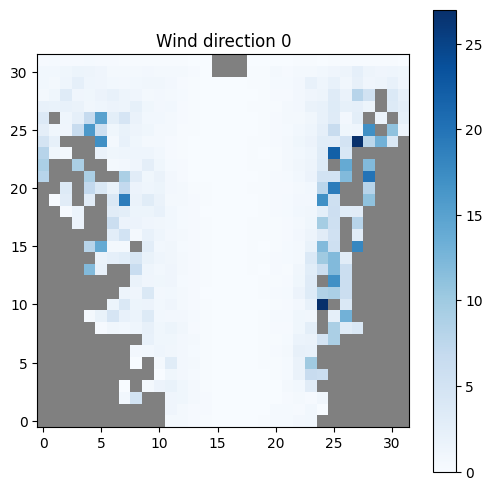

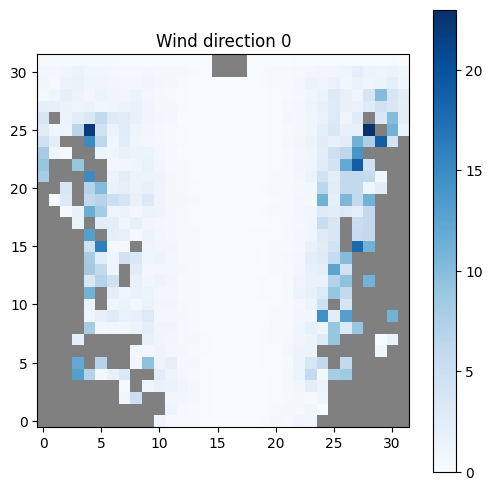


Training completed in 237.4 seconds!
Success rate: 100.0%
Average reward: 99.99
Average steps: 87.0
Q-table size: 18581 states


In [20]:
# Training parameters
sailor.learning_rate = 0.1
sailor.discount_factor = 0.99
sailor.exploration_rate = 0.3

num_episodes = 30000  # Small number for debugging
max_steps = 1000    

batch = 100
batch_mat = 15000


if still_training == False:
# This line reinitializes q table
    sailor.reset()

# Create environment with a simple initial windfield
dico_env = {}
dico_env[1] = SailingEnv(**get_initial_windfield('training_1'))
dico_env[2] = SailingEnv(**get_initial_windfield('training_2'))
dico_env[3] = SailingEnv(**get_initial_windfield('training_3'))
    
# Progress tracking
rewards_history = []
steps_history = []
success_history = []
true_rew = []

# Training loop
print(f"Starting full training with {num_episodes} episodes...")
import time
start_time = time.time()

for episode in range(num_episodes):
    i = np.random.randint(1, 4)
    env = dico_env[i]
    # Reset environment and get initial state
    sailor.set_hist()

    observation, info = env.reset(seed=episode)  # Different seed each episode
    state = sailor.discretize_state(observation)
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action and take step
        action = sailor.act(observation)
        next_observation, reward, done, truncated, info = env.step(action)
        next_state = sailor.discretize_state(next_observation)
        
        # Update Q-table
        sailor.learn(state, action, reward, next_state)
        
        # Update state and total reward
        state = next_state
        observation = next_observation
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    # Record metrics
    rewards_history.append(total_reward)
    steps_history.append(step+1)
    success_history.append(done)
    true_rew.append(np.power(sailor.discount_factor,step)*total_reward)

    # Update exploration rate (decrease over time)
    if (episode + 1) % batch_mat == 0:
        sailor.exploration_rate = 0.3
    else :
        sailor.exploration_rate = max(0.05, sailor.exploration_rate * 0.999)
    
    # Print progress every 10 episodes

    # Plot progress

    if (episode + 1) % batch == 0:
        step_avg = sum(steps_history[-batch:]) / batch
        print(f"Episode {episode+1}/{num_episodes}: Steps avg: {step_avg} - " +
              f"exp rate: {round(sailor.exploration_rate,4)} - q size: {len(sailor.q_table)}"+
               f" ({round(len(sailor.q_table)/sailor.complexity,2)})         ", end="\r")

    if (episode + 1) % batch_mat == 0:
        sailor.show_velocity(wind_=False,show=True)

training_time = time.time() - start_time

# Calculate overall success rate
success_rate = sum(success_history) / len(success_history) * 100

print(f"\nTraining completed in {training_time:.1f} seconds!")
print(f"Success rate: {success_rate:.1f}%")
print(f"Average reward: {np.mean(rewards_history):.2f}")
print(f"Average steps: {np.mean(steps_history):.1f}")
print(f"Q-table size: {len(sailor.q_table)} states")

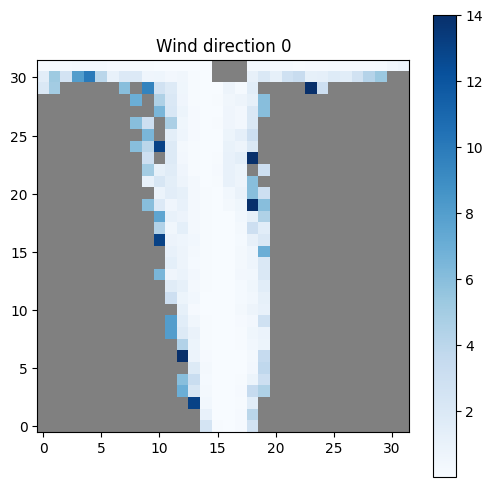

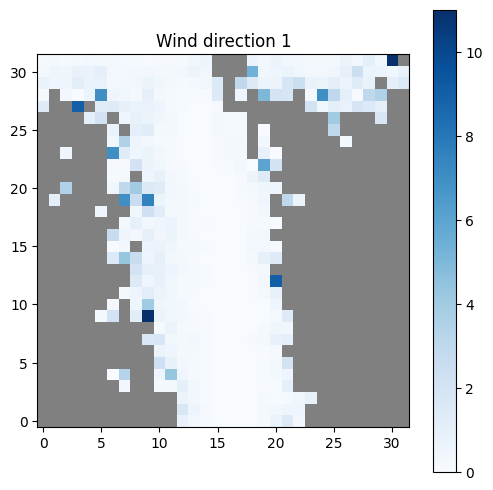

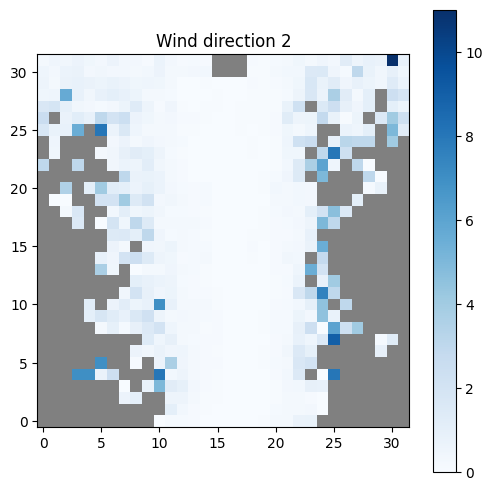

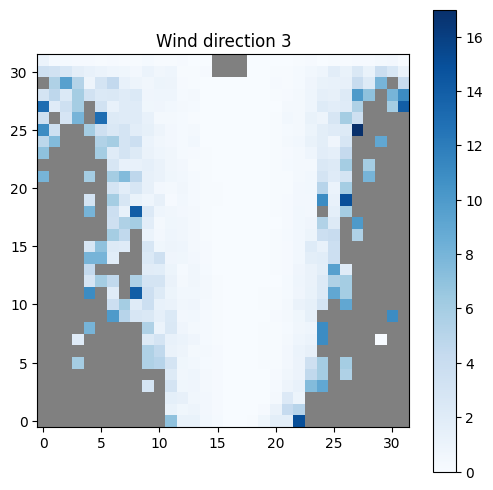

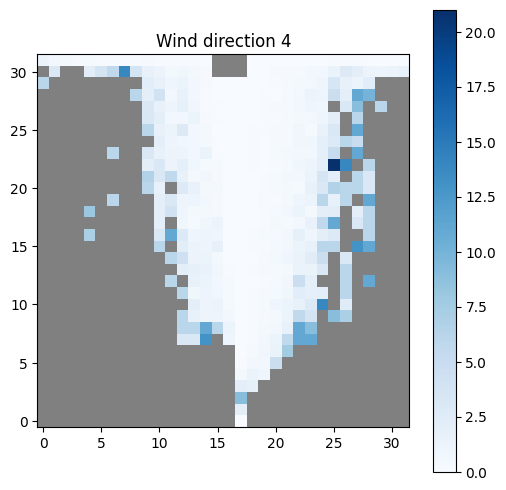

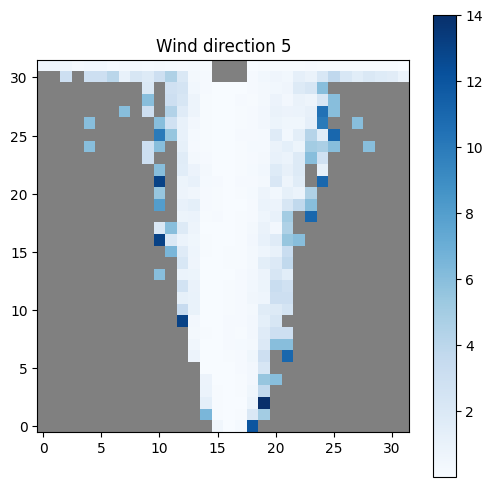

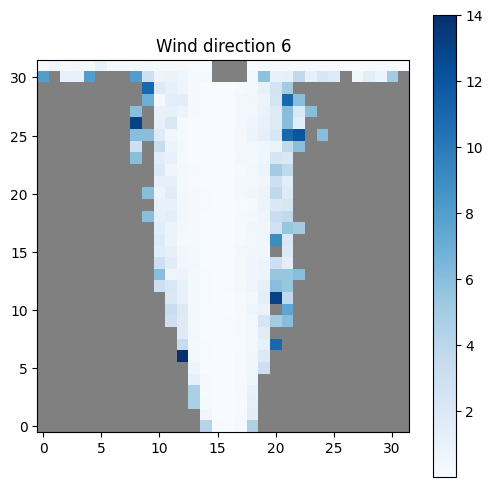

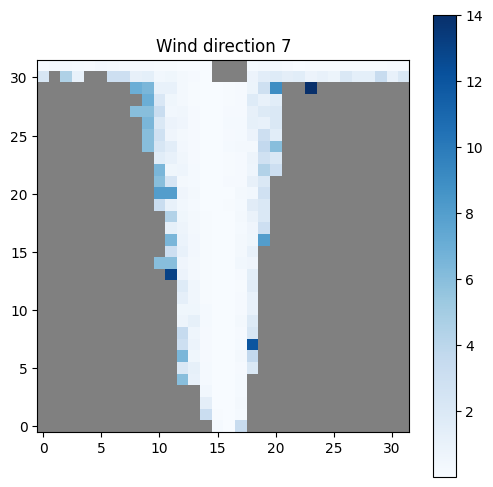

In [21]:
sailor.show_velocity(wind_=True,show=True)

### Training Performance

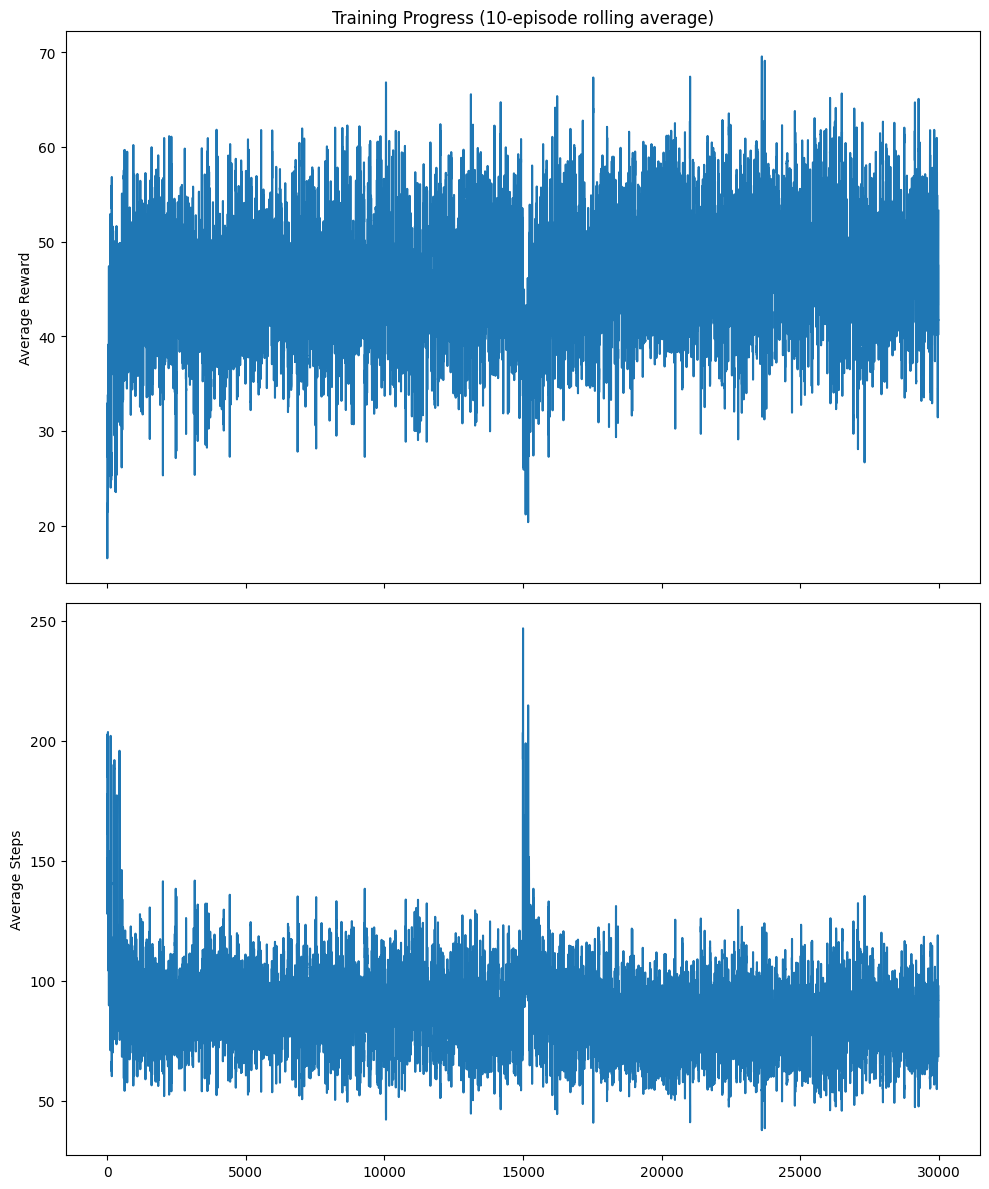

In [22]:
import matplotlib.pyplot as plt

# Calculate rolling averages
window_size = 10
rolling_rewards = np.convolve(true_rew, np.ones(window_size)/window_size, mode='valid')
rolling_steps = np.convolve(steps_history, np.ones(window_size)/window_size, mode='valid')
rolling_success = np.convolve([1 if s else 0 for s in success_history], np.ones(window_size)/window_size, mode='valid') * 100

# Create the plots
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12), sharex=True)

# Plot rewards
ax1.plot(rolling_rewards)
ax1.set_ylabel('Average Reward')
ax1.set_title('Training Progress (10-episode rolling average)')

# Plot steps
ax2.plot(rolling_steps)
ax2.set_ylabel('Average Steps')

# Plot success rate
#ax3.plot(rolling_success)
#ax3.set_ylabel('Success Rate (%)')
#ax3.set_xlabel('Episode')

plt.tight_layout()
plt.show()

### Testing

In [24]:
# Turn off exploration for evaluation
sailor.exploration_rate = 0

# Create test environment
test_env = SailingEnv(**get_initial_windfield('training_1'))

# Test parameters
num_test_episodes = 5
max_steps = 1000

print("Testing the trained agent on 5 new episodes...")
# Testing loop
for episode in range(num_test_episodes):
    # Reset environment
    observation, info = test_env.reset(seed=1000 + episode)  # Different seeds from training
    sailor.set_hist()
    
    total_reward = 0
    
    for step in range(max_steps):
        # Select action using learned policy
        action = sailor.act(observation)
        observation, reward, done, truncated, info = test_env.step(action)
        
        total_reward += reward
        
        # Break if episode is done
        if done or truncated:
            break
    
    print(f"Test Episode {episode+1}: Steps={step+1}, Reward={total_reward}, " +
          f"Position={info['position']}, Goal reached={done}")

Testing the trained agent on 5 new episodes...
Test Episode 1: Steps=111, Reward=100.0, Position=[17 30], Goal reached=True
Test Episode 2: Steps=111, Reward=100.0, Position=[17 30], Goal reached=True
Test Episode 3: Steps=73, Reward=100.0, Position=[16 30], Goal reached=True
Test Episode 4: Steps=142, Reward=100.0, Position=[16 30], Goal reached=True
Test Episode 5: Steps=148, Reward=100.0, Position=[17 30], Goal reached=True


### Saving Agent

In [26]:
# Import the utility function for saving Q-learning agents
from src.utils.agent_utils import save_qlearning_agent

# Save our trained agent
save_qlearning_agent(
    agent=sailor,
    output_path="agents/mousse_1.py",
    agent_class_name="Mousse_1"
)

Agent saved to agents/mousse_1.py
The file contains 18581 state-action pairs.
You can now use this file with validate_agent.ipynb and evaluate_agent.ipynb
